# Post-training model quantization of Conv1D example

In [1]:
# Import all the things we need ---
# by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling1D, ZeroPadding2D, Conv2D, Conv1D
from keras.utils import plot_model
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as cPickle
import random, sys, keras
import tensorflow as tf
import seaborn as sn

from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

#Function for plotting confusion matrix
def plot_confusion_matrix(cm, filename, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):   
    with PdfPages(filename) as pdf:
        # As many times as you like, create a figure fig and save it:
        fig = plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=45)
        plt.yticks(tick_marks, labels)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        pdf.savefig(fig, dpi = 1000, bbox_inches='tight')
        
        
def get_snrs(data_path):
    
    Xd = cPickle.load(open(data_path,'rb'), encoding="latin1")
    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
    
    return snrs

def load_model(json_dir, h5_dir):
    
    # Load the model
    with open(json_dir, 'r') as f:
        model = tf.keras.models.model_from_json(f.read())
    #load weights into new model
    model.load_weights(h5_dir,"r")
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    #model.summary()
    
    return model

def load_data(data_path):
    """
    Example load_data("RML2016.10a_dict.pkl")
    """
    
    print("Preparing the data ...")
    
    #==================PREPARE DATA=====================

    # Prepare the training data
    # You will need to seperately download or generate this file
    Xd = cPickle.load(open(data_path,'rb'), encoding="latin1")
    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
    X = []  
    lbl = []
    for mod in mods:
        for snr in snrs:
            X.append(Xd[(mod,snr)])
            for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
    X = np.vstack(X)

    # Partition the data into training, validation, and test sets while keeping SNR and Mod labels handy for each
    np.random.seed(2016)

    #Number of samples
    n_examples = X.shape[0]
    n_train = int(n_examples * 0.6)
    n_val = int(n_examples * 0.2)

    train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
    val_idx = np.random.choice(list(set(range(0,n_examples))-set(train_idx)), size=n_val, replace=False)
    test_idx = list(set(range(0,n_examples))-set(train_idx)-set(val_idx))

    X_train = X[train_idx]
    X_val = X[val_idx]
    X_test =  X[test_idx]

    def to_onehot(yy):
        yy1 = np.zeros([len(yy), max(yy)+1])
        yy1[np.arange(len(yy)),yy] = 1
        return yy1

    Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
    Y_val = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), val_idx)))
    Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

    #Flip the last two dimensions
    X_train = X_train.reshape((X_train.shape[0],X_train.shape[2],X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0],X_val.shape[2],X_val.shape[1]))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[2],X_test.shape[1]))

    #Print out the shapes for different datasets
    print ("Total number of samples: ", X.shape[0])
    print ("number of training examples = " + str(X_train.shape[0]))
    print ("number of validation examples = " + str(X_val.shape[0]))
    print ("number of test examples = " + str(X_test.shape[0]))

    print ("X_train shape: " + str(X_train.shape))
    print ("Y_train shape: " + str(Y_train.shape))

    print ("X_val shape: " + str(X_val.shape))
    print ("Y_val shape: " + str(Y_val.shape))

    print ("X_test shape: " + str(X_test.shape))
    print ("Y_test shape: " + str(Y_test.shape))

    #Input shape and number of classes
    in_shape = list(X_train.shape[1:])
    classes = mods
    num_classes = len(classes)

    print("Number of classes: ", num_classes)

    return X_test, Y_test, classes

Using TensorFlow backend.


## Post quantization using hls4ml

In [4]:
!ls

CNN                      RML2016.10a_dict.pkl     prune_performance.ipynb
README.md                model_quantization.ipynb


In [3]:
!rm -rf test_1/ test_1.tar.gz

In [5]:
import hls4ml

# Load full the model
full_model = load_model("./CNN/model/Conv1D-full.json", "./CNN/model/Conv1D-full.h5")
pruned_model = load_model("./CNN/model/Conv1D-0.85.json", "./CNN/model/Conv1D-0.85.h5")

#Create the quantized + pruned model
#Generate the config
config = hls4ml.utils.config_from_keras_model(pruned_model, granularity='model')

config['IOType'] = 'io_stream'
config['Model']['Strategy'] = 'Resource'
config['Model']['Precision'] = 'ap_fixed<32,6>'
config['Model']['ReuseFactor'] = 500
config['LayerName'] = {}
config['LayerName']['activation']= {}
config['LayerName']['activation']['Strategy'] = 'Stable'
print(config)


Interpreting Sequential
Topology:
Layer name: conv1, layer type: Conv1D
  -> Activation (relu), layer name: conv1
Layer name: conv2, layer type: Conv1D
  -> Activation (relu), layer name: conv2
Layer name: max_pooling1d, layer type: MaxPooling1D
Layer name: conv3, layer type: Conv1D
  -> Activation (relu), layer name: conv3
Layer name: conv4, layer type: Conv1D
  -> Activation (relu), layer name: conv4
Layer name: conv5, layer type: Conv1D
  -> Activation (relu), layer name: conv5
Layer name: conv6, layer type: Conv1D
  -> Activation (relu), layer name: conv6
Layer name: max_pooling1d_1, layer type: MaxPooling1D
Layer name: dense1, layer type: Dense
  -> Activation (relu), layer name: dense1
Layer name: dense2, layer type: Dense
  -> Activation (linear), layer name: dense2
Layer name: activation, layer type: Activation
{'Model': {'Precision': 'ap_fixed<32,6>', 'ReuseFactor': 500, 'Strategy': 'Resource'}, 'IOType': 'io_stream', 'LayerName': {'activation': {'Strategy': 'Stable'}}}


In [6]:
hls_model = hls4ml.converters.convert_from_keras_model(pruned_model, hls_config=config, output_dir='test_1')
hls_model.compile()

Interpreting Sequential
Input shape: [128, 2]
Topology:
Layer name: conv1, layer type: Conv1D, current shape: [[None, 128, 2]]
Layer name: conv2, layer type: Conv1D, current shape: [[None, 126, 128]]
Layer name: max_pooling1d, layer type: MaxPooling1D, current shape: [[None, 124, 128]]
Layer name: conv3, layer type: Conv1D, current shape: [[None, 62, 128]]
Layer name: conv4, layer type: Conv1D, current shape: [[None, 60, 64]]
Layer name: conv5, layer type: Conv1D, current shape: [[None, 58, 64]]
Layer name: conv6, layer type: Conv1D, current shape: [[None, 56, 32]]
Layer name: max_pooling1d_1, layer type: MaxPooling1D, current shape: [[None, 54, 32]]
Layer name: dense1, layer type: Dense, current shape: [[None, 27, 32]]
Layer name: dense2, layer type: Dense, current shape: [[None, 128]]
Layer name: activation, layer type: Softmax, current shape: [[None, 11]]
Creating HLS model
Writing HLS project
Done


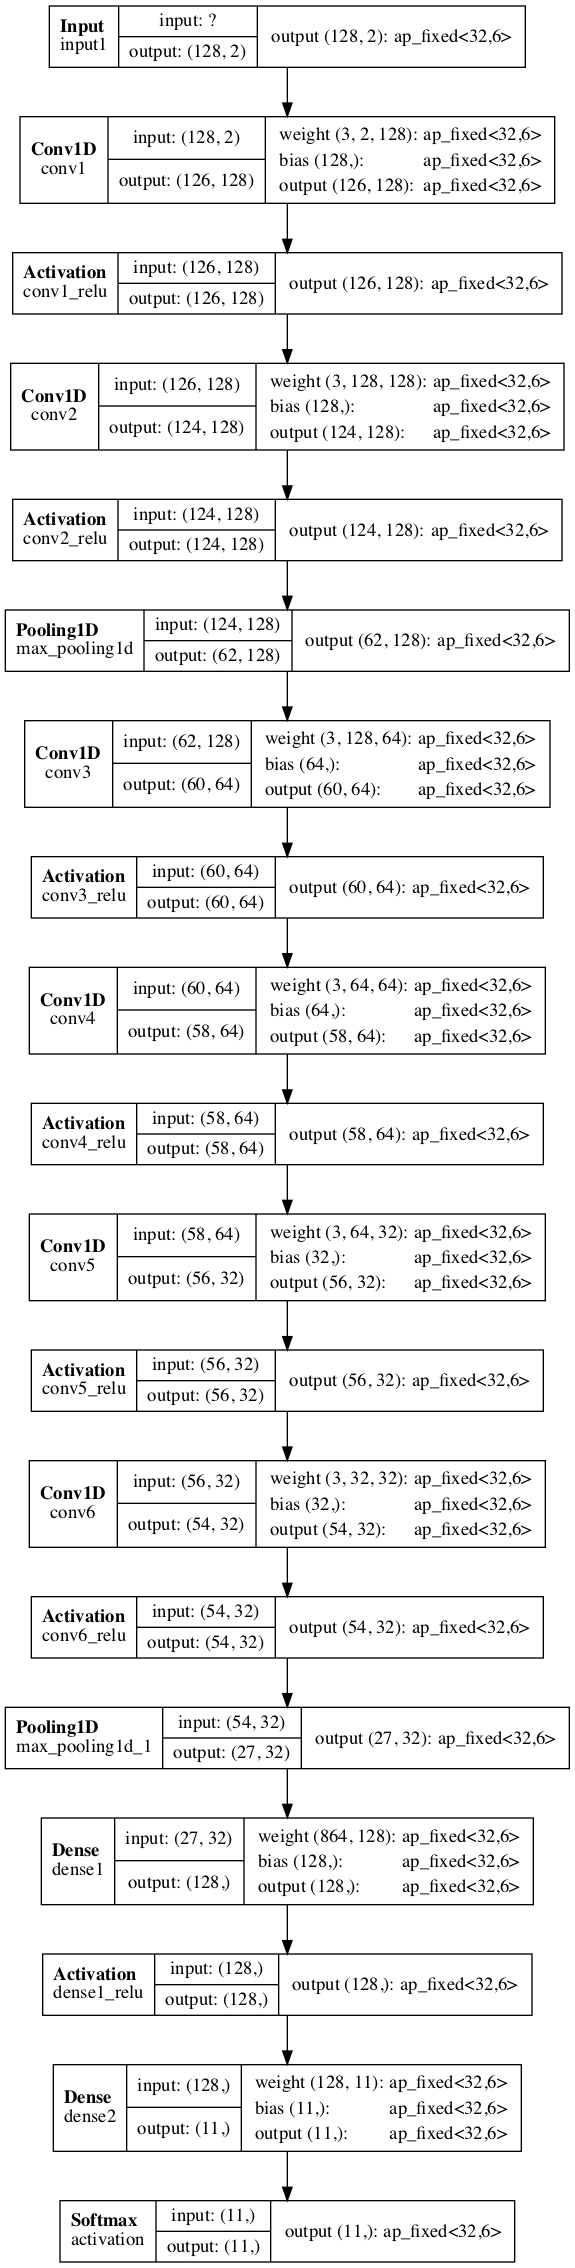

In [7]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [8]:
X_test, Y_test, classes = load_data("RML2016.10a_dict.pkl")
X_test = X_test[:1000]
Y_test = Y_test[:1000]

Preparing the data ...
Total number of samples:  220000
number of training examples = 132000
number of validation examples = 44000
number of test examples = 44000
X_train shape: (132000, 128, 2)
Y_train shape: (132000, 11)
X_val shape: (44000, 128, 2)
Y_val shape: (44000, 11)
X_test shape: (44000, 128, 2)
Y_test shape: (44000, 11)
Number of classes:  11


In [9]:
#Make predictions
Y_pred_full = full_model.predict(X_test)
Y_pred_pruned = pruned_model.predict(X_test)
Y_pred_quant = hls_model.predict(X_test)

In [9]:
n_classes = 11

# Compute ROC curve and ROC area for each class
fpr_full = dict()
tpr_full = dict()
roc_auc_full = dict()

fpr_pruned = dict()
tpr_pruned = dict()
roc_auc_pruned = dict()

fpr_quant = dict()
tpr_quant = dict()
roc_auc_quant = dict()

sum_pruned_ratio = 0
sum_quant_ratio = 0

for i in range(n_classes):
    
    #AUC from the full model
    fpr_full[i], tpr_full[i], _ = roc_curve(Y_test[:, i], Y_pred_full[:, i])
    roc_auc_full[i] = auc(fpr_full[i], tpr_full[i])
    print('Output {}: Keras auc = {:.1f}'.format(classes[i], roc_auc_full[i] * 100))
    
    #AUC of pruned model
    fpr_pruned[i], tpr_pruned[i], _ = roc_curve(Y_test[:, i], Y_pred_pruned[:, i])
    roc_auc_pruned[i] = auc(fpr_pruned[i], tpr_pruned[i])
    print('Output {}: Pruned Keras auc = {:.1f}'.format(classes[i], roc_auc_pruned[i] * 100))
    print('Output {}: Ratio Pruned/Full = {:.2f}'. format(classes[i], roc_auc_pruned[i]/roc_auc_full[i])) #Calculate the ratio
    sum_pruned_ratio += roc_auc_pruned[i]/roc_auc_full[i]
    
    #AUC of quantized model
    fpr_quant[i], tpr_quant[i], _ = roc_curve(Y_test[:, i], Y_pred_quant[:, i])
    roc_auc_quant[i] = auc(fpr_quant[i], tpr_quant[i])
    print('Output {}: Keras auc = {:.1f}'.format(classes[i], roc_auc_quant[i] * 100))
    print('Output {}: Ratio Quantized/Full = {:.2f}'. format(classes[i], roc_auc_quant[i]/roc_auc_full[i])) #Calculate the rat
    sum_quant_ratio += roc_auc_quant[i]/roc_auc_full[i]

print("Average ratio pruned/full: {:.2f}".format(sum_pruned_ratio/n_classes))
print("Average ratio quant/full: {:.2f}".format(sum_quant_ratio/n_classes))

Output 8PSK: Keras auc = 99.6
Output 8PSK: Pruned Keras auc = 99.4
Output 8PSK: Ratio Pruned/Full = 1.00
Output 8PSK: Keras auc = 42.9
Output 8PSK: Ratio Quantized/Full = 0.43
Output AM-DSB: Keras auc = nan
Output AM-DSB: Pruned Keras auc = nan
Output AM-DSB: Ratio Pruned/Full = nan
Output AM-DSB: Keras auc = nan
Output AM-DSB: Ratio Quantized/Full = nan
Output AM-SSB: Keras auc = nan
Output AM-SSB: Pruned Keras auc = nan
Output AM-SSB: Ratio Pruned/Full = nan
Output AM-SSB: Keras auc = nan
Output AM-SSB: Ratio Quantized/Full = nan
Output BPSK: Keras auc = nan
Output BPSK: Pruned Keras auc = nan
Output BPSK: Ratio Pruned/Full = nan
Output BPSK: Keras auc = nan
Output BPSK: Ratio Quantized/Full = nan
Output CPFSK: Keras auc = nan
Output CPFSK: Pruned Keras auc = nan
Output CPFSK: Ratio Pruned/Full = nan
Output CPFSK: Keras auc = nan
Output CPFSK: Ratio Quantized/Full = nan
Output GFSK: Keras auc = nan
Output GFSK: Pruned Keras auc = nan
Output GFSK: Ratio Pruned/Full = nan
Output GFSK: 

/Users/duc_hoang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
